In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC

In [32]:
df = pd.read_csv("https://raw.githubusercontent.com/Christo2810/ds-and-ml/refs/heads/main/balanced_thyroid_dataset%20(1).csv")

print(df.head())
print(df.info())
print(df.describe())

   Age  FTI  FTI Measured  Goitre  Hypopituitary  I131 Treatment  Lithium  \
0   41    0             0       0              0               0        0   
1   23    0             0       0              0               0        0   
2   46    1             0       0              0               0        0   
3   70    0             1       0              0               0        0   
4   70    0             0       0              0               0        0   

   On Antithyroid Medication  On Thyroxine  Pregnant  ...  T3 Measured  T4U  \
0                          0             0         0  ...         1.30    1   
1                          0             0         0  ...         4.10    1   
2                          0             0         0  ...         0.98    0   
3                          0             0         0  ...         0.16    1   
4                          0             0         0  ...         0.72    1   

   T4U Measured  TSH  TSH Measured  TT4  TT4 Measured  Thyroid

In [33]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Age                          0
FTI                          0
FTI Measured                 0
Goitre                       0
Hypopituitary                0
I131 Treatment               0
Lithium                      0
On Antithyroid Medication    0
On Thyroxine                 0
Pregnant                     0
Psych                        0
Query 1                      0
Query 2                      0
Query on Thyroxine           0
3                            0
T3                           0
T3 Measured                  0
T4U                          0
T4U Measured                 0
TSH                          0
TSH Measured                 0
TT4                          0
TT4 Measured                 0
Thyroid Surgery              0
Tumor                        0
Category                     0
dtype: int64


In [34]:
X = df.drop(columns=['Category'])
y = df['Category']

In [35]:
scale_cols = ['TSH Measured', 'Tumor']
scaler = StandardScaler()
X[scale_cols] = scaler.fit_transform(X[scale_cols])

In [36]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


Selected Features: ['T3 Measured', 'T4U Measured', 'TSH Measured', 'Tumor', 'TT4 Measured', 'Age', 'FTI', 'FTI Measured', 'T4U', 'T3']


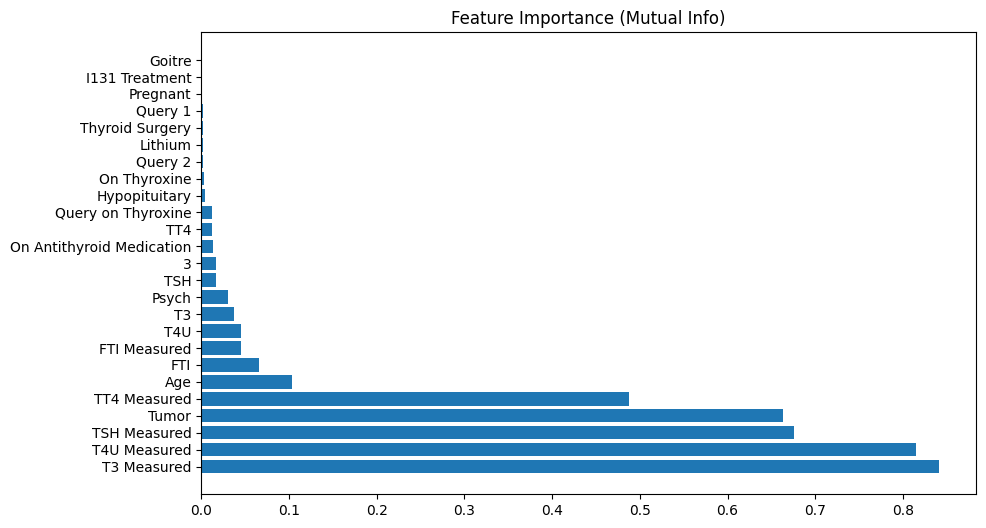

In [37]:
mutual_info = mutual_info_classif(X_train, y_train)
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Mutual Info': mutual_info
}).sort_values(by='Mutual Info', ascending=False)

selected_features = feature_scores['Feature'].head(10).tolist()
print("\nSelected Features:", selected_features)

plt.figure(figsize=(10,6))
plt.barh(feature_scores['Feature'], feature_scores['Mutual Info'])
plt.title("Feature Importance (Mutual Info)")
plt.show()

In [38]:
X_train_clean = X_train[selected_features].copy()

for f in selected_features:
    Q1 = X_train_clean[f].quantile(0.25)
    Q3 = X_train_clean[f].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    mask = (X_train_clean[f] >= lower) & (X_train_clean[f] <= upper)
    X_train_clean = X_train_clean[mask]

y_train_clean = y_train.loc[X_train_clean.index]

print("\nTraining Data After Outlier Cleaning:", X_train_clean.shape)


Training Data After Outlier Cleaning: (4167, 10)


In [39]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}

for kernel in kernels:
    print(f"\nTraining SVM with kernel: {kernel}")
    svm_model = SVC(kernel=kernel, gamma='scale')
    svm_model.fit(X_train_clean, y_train_clean)

    y_pred = svm_model.predict(X_test[selected_features])
    acc = accuracy_score(y_test, y_pred)
    results[kernel] = (acc, y_pred)



Training SVM with kernel: linear

Training SVM with kernel: poly

Training SVM with kernel: rbf

Training SVM with kernel: sigmoid


In [40]:
print("\n Accuracy for All SVM Kernels:\n")
for k, v in results.items():
    print(f"{k}: {v[0]:.4f}")


 Accuracy for All SVM Kernels:

linear: 0.8438
poly: 0.6441
rbf: 0.7072
sigmoid: 0.3936


In [41]:
best_kernel = max(results, key=lambda k: results[k][0])
best_accuracy, best_pred = results[best_kernel]

print(f"\n Best Kernel: {best_kernel} (Accuracy = {best_accuracy:.4f})")


 Best Kernel: linear (Accuracy = 0.8438)


In [42]:
print("\nClassification Report:\n")
print(classification_report(y_test, best_pred, zero_division=1))


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.69      0.76       551
           1       0.83      0.92      0.88       557
           2       0.85      0.94      0.90       544
           3       0.84      0.81      0.83       551

    accuracy                           0.84      2203
   macro avg       0.84      0.84      0.84      2203
weighted avg       0.84      0.84      0.84      2203



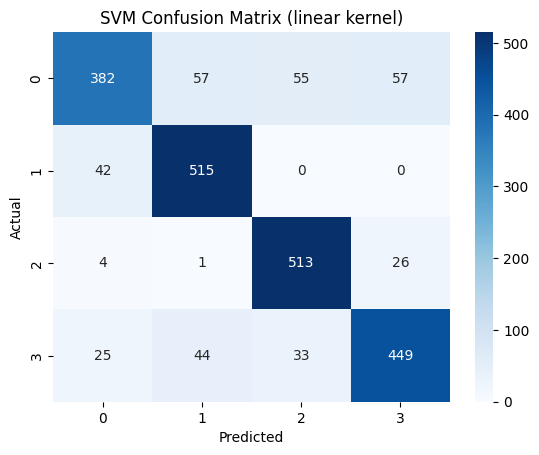

In [43]:
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.title(f"SVM Confusion Matrix ({best_kernel} kernel)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()